In [1]:
import numpy as np
from typing import Tuple
from joblib import Parallel, delayed

In [2]:
from maze import Maze

# Constants
GAME_HEIGHT = 600
GAME_WIDTH = 600
NUMBER_OF_TILES = 25
SCREEN_HEIGHT = 700
SCREEN_WIDTH = 700
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
    "X XXXXXXXX          XXXXX",
    "X XXXXXXXX  XXXXXX  XXXXX",
    "XP     XXX  XXXXXX  XXXXX",
    "X      XXX  XXX         X",
    "XXXXXX  XX  XXX        XX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "XXXXXX  XX  XXXXXX  XXXXX",
    "X  XXX      XXXXXXXXXXXXX",
    "X  XXX  XXXXXXXXXXXXXXXXX",
    "X         XXXXXXXXXXXXXXX",
    "X             XXXXXXXXXXX",
    "XXXXXXXXXXX      XXXXX  X",
    "XXXXXXXXXXXXXXX  XXXXX  X",
    "XXX  XXXXXXXXXX         X",
    "XXX                     X",
    "XXX         XXXXXXXXXXXXX",
    "XXXXXXXXXX  XXXXXXXXXXXXX",
    "XXXXXXXXXX              X",
    "XX   XXXXX              X",
    "XX   XXXXXXXXXXXXX  XXXXX",
    "XX    XXXXXXXXXXXX  XXXXX",
    "XX        XXXX          X",
    "XXXX                    X",
    "XXXXXXXXXXXXXXXXXXXXXXXXX",
]

env = Maze(
    level,
    goal_pos=(23, 20),
    MAZE_HEIGHT=GAME_HEIGHT,
    MAZE_WIDTH=GAME_WIDTH,
    SIZE=NUMBER_OF_TILES,
)

In [3]:
NO_OF_ACTIONS = 4

In [4]:
policy_probs = np.full((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS), 0.25)
state_values = np.zeros((env.number_of_tiles, env.number_of_tiles))

In [5]:

def policy(state:Tuple[int, int]):
    return env.policy_probs[state]

In [6]:
def policy_evaluation(state_values, policy_probs, gamma = 0.99, theta = 1e-6):
    delta = float("inf")
    while delta > theta:
        delta = 0

        for row in range(env.number_of_tiles):
            for col in range(env.number_of_tiles):
                if (row,col) in env.maze:
                    old_value = state_values[row,col]
                    new_value = 0
                    action_probs = policy_probs[(row,col)]

                    for action, prob in enumerate(action_probs):
                        next_state, reward, _ = env.simulate_step((row, col), action)
                        new_value += prob * (reward + gamma* state_values[next_state])
                    
                    env.state_values[(row,col)] = new_value

                    delta = max(delta, abs(new_value - old_value))



In [7]:
def policy_improvement(state_values, policy_probs, gamma=0.99):
    
    policy_stable = True

    for row in range(env.number_of_tiles):
        for col in range(env.number_of_tiles):
            if (row, col) in env.maze:
                old_action = np.argmax(policy_probs[(row, col)])
                new_action = None

                max_q = float("-inf")

                for action in range(NO_OF_ACTIONS):
                    next_state, reward, _ = env.simulate_step((row, col), action)
                    val = reward + gamma * state_values[next_state]
                    
                    if val>max_q:
                        new_action = action
                        max_q = val

                action_probs = np.zeros(shape = (NO_OF_ACTIONS))
                action_probs[new_action] = 1
                policy_probs[(row, col)] = action_probs

                if new_action != old_action:
                    policy_stable = False
                
    return policy_stable



In [8]:
def policy_iteration(state_values, policy_probs, theta=1e-6, gamma = 0.99):

    policy_stable = False
    i = 0
    while not policy_stable:
        i += 1
        policy_evaluation(state_values, policy_probs, gamma, theta)
        policy_stable = policy_improvement(state_values, policy_probs)
        print(i)

In [9]:
# policy_iteration(state_values, policy_probs)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_policy(probs_or_qvals, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'L', 1: 'U', 2: 'R', 3: 'D'}
    fig = plt.figure(figsize=(7,7))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(np.object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2)
    plt.axis("off")
    plt.suptitle("Policy", size=24)
    plt.tight_layout()

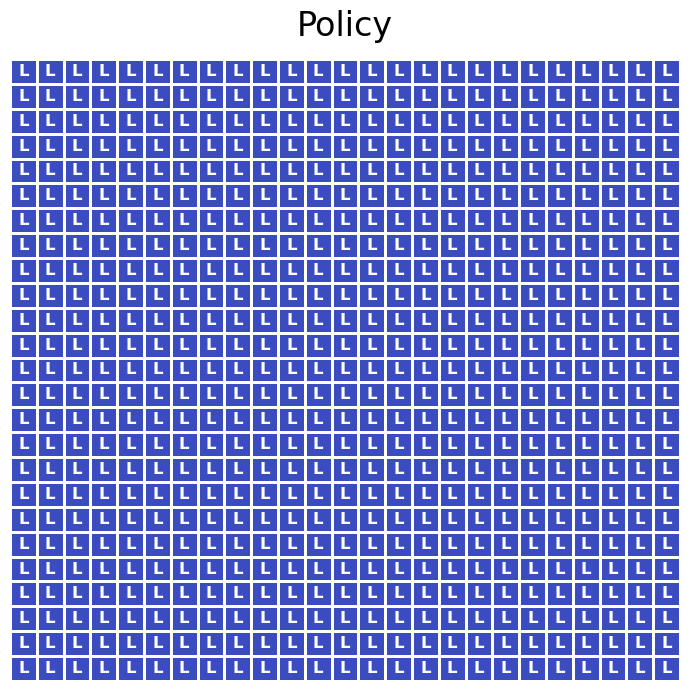

In [11]:
plot_policy(policy_probs)

In [12]:
action_values = np.zeros((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS))
# action_values = np.full((env.number_of_tiles, env.number_of_tiles, NO_OF_ACTIONS), -100)
# # set action value for goal state to 0
# action_values[env.goal_pos]=0

In [13]:
def policy(state, epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))


In [14]:
def run_episode(action_values, epsilon = 0.8, gamma = 0.99, alpha = 0.2):
    env.state = env.reset_state()
    transitions = []
    done = False
    G = 0

    while not done:
        # print(env.state)
        prev_state = env.state
        action = policy(env.state, epsilon)
        next_state, reward, done = env.step(action)
        transitions.append((prev_state, action, reward))
        env.state = next_state


        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] += alpha * (G - qsa)
    
    return action_values

In [15]:
import numpy as np
from tqdm.auto import tqdm

def mc_on_policy_control(action_values, episodes, gamma=0.99, epsilon=0.9, alpha = 0.2):

    for episode in tqdm(range(1,episodes+1)):
        run_episode(action_values, gamma, epsilon, alpha)
        

In [16]:
mc_on_policy_control(action_values, 400)

# result = Parallel(n_jobs=-1)(delayed(run_episode)(action_values) for _ in tqdm(range(500)))

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
result[-1]

array([[[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ,   0.        ],
        [-99.99984675, -99.99999655, -99.99999461, -99.99998684],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ,   0.        ],
        [-99.99995983, -99.99998684, -99.99776993, -99.99990192],
        [  0.        ,   0.        ,   0.     

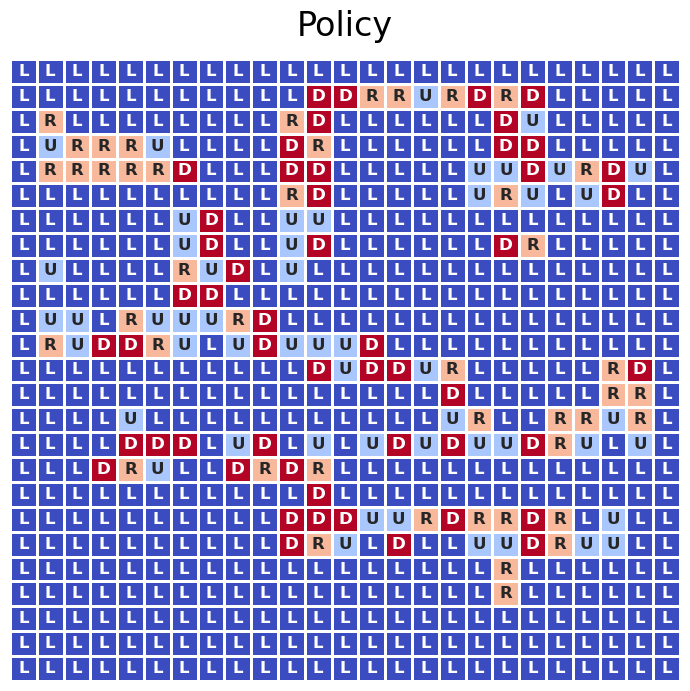

In [ ]:
plot_policy(result[-1])

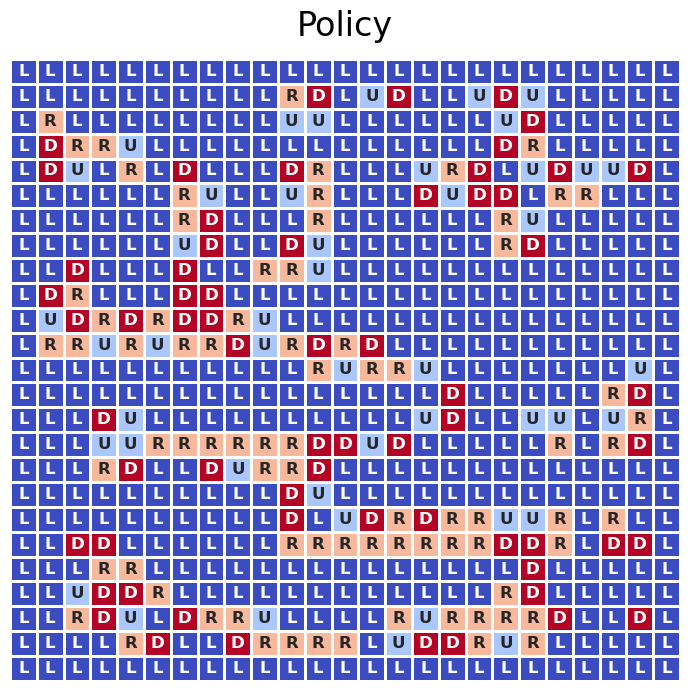

In [ ]:
actions = np.load("action.npy")
plot_policy(actions)